<a href="https://colab.research.google.com/github/aleksandr-del/machine-learning-algorithms-from-scratch/blob/main/simple_neural_network_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация изображений

Импортируем необходимые библиотеки:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ReLU

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from tqdm import tqdm

## Загрузка данных

Загрузим данные с [соревнования](https://www.kaggle.com/competitions/digit-recognizer/overview) в Kaggle:

In [ ]:
df = pd.read_csv('/content/drive/Datasets/MNIST/train.csv')
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


У нас 42 000 изображений размером 28 на 28 пикселей каждое (784 признака). Первый столбец - это метка класса: цифра от 0 до 9.

Визуализируем четвертое изображение:

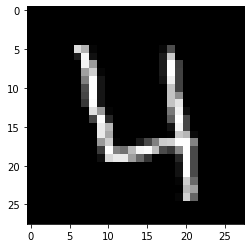

In [ ]:
plt.imshow(df.loc[3][1:].values.reshape((28, 28)),
           cmap='gray')
plt.show()

## Подготовка данных

Сохраним признаки в переменной `X`, а метку -  в `y`. Признаки нормализуем, поделив каждое значение на 255:

In [ ]:
X = df.drop(columns='label').values / 255

In [ ]:
y = df['label'].values

Разделим данные на обучающую и валидационную выборки:

In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X,
                                                      y,
                                                      random_state=42,
                                                      test_size=0.2)

Размеры выборок:

In [ ]:
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape)

(33600, 784) (33600,) (8400, 784) (8400,)


## Простая модель

Инициализируем веса. У нас на выходе 10 нейронов (соответствует 10 классам изображений), на вход подается 784 признака (каждого изображения). Получается, что нам надо оптимизировать 7 840 параметров модели:

In [ ]:
np.random.normal(size=(784, 10))

array([[-1.61484191, -0.9732893 , -0.18389531, ..., -0.32361132,
        -0.27274104, -0.78945919],
       [-0.83861816, -1.0361496 , -0.33159661, ..., -0.7228115 ,
         1.1200564 , -0.41840359],
       [-0.42712218, -1.23212237,  0.37792964, ..., -0.09340681,
        -1.51754905,  0.21854822],
       ...,
       [ 1.06750257, -1.45742622, -1.02009386, ..., -0.81548505,
        -0.17245265,  1.07292694],
       [ 1.57247161, -0.52761624,  0.93579744, ...,  0.53412042,
         0.30125902,  1.47063963],
       [-0.75798599, -2.18713772, -0.1054436 , ...,  0.61614724,
         0.23179493,  1.03375018]])

Для стабильности спуска нормируем значения весов:

In [ ]:
np.random.normal(size=(784, 10)) / np.sqrt(784)

array([[-0.05053053, -0.03123323,  0.02675138, ..., -0.05625828,
         0.03163289, -0.06368265],
       [ 0.00770369,  0.04892771,  0.02310002, ..., -0.03679837,
         0.01817353, -0.01172231],
       [ 0.02928925, -0.00995786,  0.0009529 , ..., -0.02650494,
         0.00408178, -0.03401202],
       ...,
       [-0.00765751, -0.01953113, -0.00514539, ...,  0.01794031,
         0.01413299, -0.0108664 ],
       [ 0.01861644,  0.00272797, -0.00937747, ..., -0.047041  ,
         0.04376245,  0.00402968],
       [ 0.02789772, -0.00345349, -0.00241755, ..., -0.06373166,
         0.05665611, -0.01092475]])

Конвертируем в тензор:

In [ ]:
weights = torch.tensor(np.random.normal(size=(784, 10)) / np.sqrt(784),
                       requires_grad=True)

Конвертируем обучающую выборку в тензор:

In [ ]:
X_tensor = torch.tensor(train_X)
y_tensor = torch.tensor(train_y)

Инициализируем оптимизатор:

In [ ]:
optimizer = torch.optim.SGD(params=[weights], lr=0.1)

Запускаем цикл обучения:

In [ ]:
%%time
# Создаем пустой список, чтобы записывать в него результат вычислений функции потерь
loss_history = []

# 1000 шагов обучения
for _ in range(1000):
    # считаем произведение матрицы признаков на матрицу весов
    prediction = X_tensor @ weights
    # вычисляем функцию потерь, функция активации уже включена
    loss = torch.nn.functional.cross_entropy(prediction, y_tensor) 
    # вычисляем градиент
    loss.backward()
    # делаем шаг градиентного спуска: обновляем веса
    optimizer.step()
    # записываем значение функции потерь
    loss_history.append(loss.data.numpy())
    # обнуляем градиенты для следующего шага
    optimizer.zero_grad()

CPU times: user 3min 5s, sys: 152 ms, total: 3min 5s
Wall time: 3min 6s


Визуализируем, как изменялось значение функции потерь во время обучения:

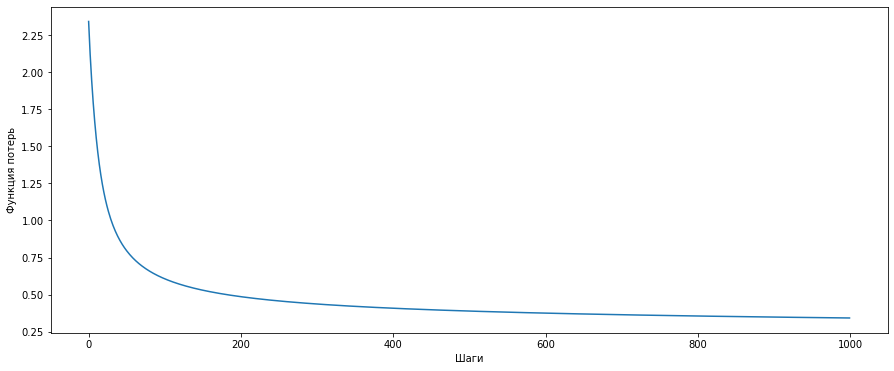

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(loss_history)
plt.xlabel('Шаги')
plt.ylabel('Функция потерь')
plt.show()

Посмотрим на нейроны:

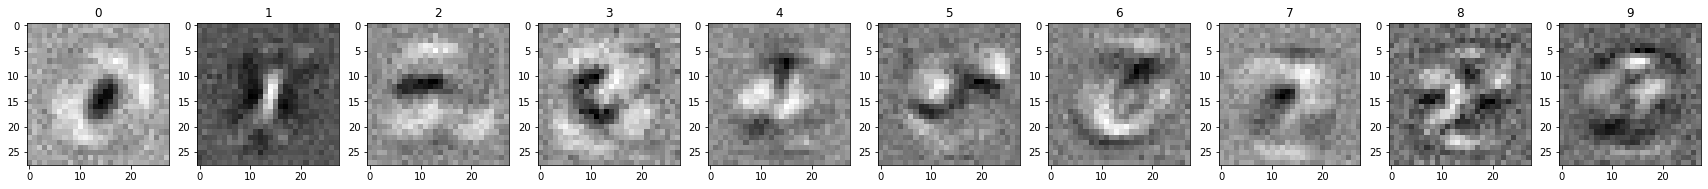

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(30,30))

for i in range(10):
    axes[i].set_title(i)
    img = weights[:, i].data.numpy().reshape((28, 28))
    axes[i].imshow(img, cmap='gray')


Пропустим выходы через сигмоиду и посчитаем метрику качества на тестовой выборке:

In [ ]:
# посчитаем логиты
logits = (X_tensor @ weights).data
# подадим логиты сигмоидной функции и посчитаем вероятности каждого класса
proba = torch.sigmoid(logits).data.numpy()
# найдем классы: для каждого изображения (состоит из строки с 10 элементами) найдем индекс, который соответствует цифре, с наибольшим значением
prediction = np.argmax(proba, axis=1)
# посчитаем метрику F1
print(f'F1-score: {f1_score(train_y, prediction, average="macro")}')

F1-score: 0.9031964575603503


## Усложняем сеть

Создадим нейросеть с одним скрытым слоем и функцией активацей ReLU:

In [ ]:
class MyFirstNN(nn.Module):
    def __init__(self, hidden_neurons=200):
        super().__init__()
        
        self.layer_1 = nn.Linear(784, hidden_neurons)
        self.layer_2 = nn.Linear(hidden_neurons, 10)

    def forward(self, X):
        y = self.layer_1(X)
        y = F.relu(y)
        output = self.layer_2(y)

        return output

Преобразуем валидационную выборку в тензор:

In [ ]:
X_valid_tensor = torch.tensor(valid_X)
y_valid_tensor = torch.tensor(valid_y)

Инициализируем модель:

In [ ]:
model = MyFirstNN()

Инициализируем оптимизатор:

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

Запускаем цикл обучения:

In [ ]:
epochs = 100

train_loss_history = []
valid_loss_history = []

for i in tqdm(range(epochs)):
    # считаем произведение матрицы признаков на матрицу весов
    prediction = model(X_tensor.to(torch.float32))
    # вычисляем функцию потерь, функция активации уже включена
    loss = torch.nn.functional.cross_entropy(prediction, y_tensor) 
    # вычисляем градиент
    loss.backward()
    # делаем шаг градиентного спуска: обновляем веса
    optimizer.step()
    # записываем значение функции потерь
    train_loss_history.append(loss.item())
    # обнуляем градиенты для следующего шага
    optimizer.zero_grad()

    #валидация на валидационной выборке
    val_prediction = model(X_valid_tensor.to(torch.float32))
    val_loss = torch.nn.functional.cross_entropy(val_prediction, y_valid_tensor)
    valid_loss_history.append(val_loss.item())


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Визуализируем значения функции потерь при обучении:

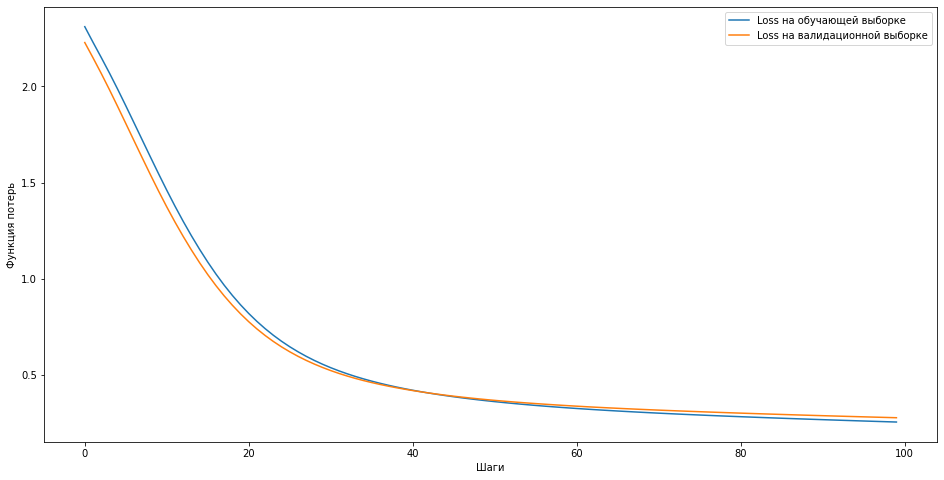

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(train_loss_history, label='Loss на обучающей выборке')
plt.plot(valid_loss_history, label='Loss на валидационной выборке')
plt.xlabel('Шаги')
plt.ylabel('Функция потерь')
plt.legend()
plt.yticks()
plt.show()

Пропустим выходы через сигмоиду и посчитаем метрику качества на валидационной выборке:

In [ ]:
# посчитаем логиты
logits = model(X_valid_tensor.to(torch.float32)).detach()
# подадим логиты сигмоидной функции и посчитаем вероятности каждого класса
proba = torch.sigmoid(logits).numpy()
# найдем классы: для каждого изображения (состоит из строки с 10 элементами) найдем индекс, который соответствует цифре, с наибольшим значением
prediction = np.argmax(proba, axis=1)
# посчитаем метрику F1
print(f'F1-score: {f1_score(valid_y, prediction, average="macro")}')

F1-score: 0.9197883389802097


## Делаем сеть еще сложнее

Создадим нейросеть с несколькими скрытыми слоями и функцией активации ReLU:

In [ ]:
class MySecondNN(nn.Module):
    def __init__(self, hidden_neurons=200):
        super().__init__()
        
        self.layer_1 = nn.Linear(784, 256)
        self.layer_2 = nn.Linear(256, hidden_neurons)
        self.layer_3 = nn.Linear(hidden_neurons, hidden_neurons)
        self.layer_4 = nn.Linear(hidden_neurons, 10)
        

    def forward(self, X):
        y = F.relu(self.layer_1(X))
        y = F.relu(self.layer_2(y))
        y = F.relu(self.layer_3(y))
        output = self.layer_4(y)

        return output

Инициализируем модель:

In [ ]:
model = MySecondNN()

Инициализируем оптимизатор:

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

Запускаем цикл обучения:

In [ ]:
epochs = 150

train_loss_history = []
valid_loss_history = []

for i in tqdm(range(epochs)):
    # считаем произведение матрицы признаков на матрицу весов
    prediction = model(X_tensor.to(torch.float32))
    # вычисляем функцию потерь, функция активации уже включена
    loss = torch.nn.functional.cross_entropy(prediction, y_tensor) 
    # вычисляем градиент
    loss.backward()
    # делаем шаг градиентного спуска: обновляем веса
    optimizer.step()
    # логируем значение функции потерь
    train_loss_history.append(loss.item())
    # обнуляем градиенты для следующего шага
    optimizer.zero_grad()

    #валидация на валидационной выборке
    val_prediction = model(X_valid_tensor.to(torch.float32))
    val_loss = torch.nn.functional.cross_entropy(val_prediction, y_valid_tensor)
    valid_loss_history.append(val_loss.item())


100%|██████████| 150/150 [05:44<00:00,  2.30s/it]


Визуализируем значения функции потерь при обучении:

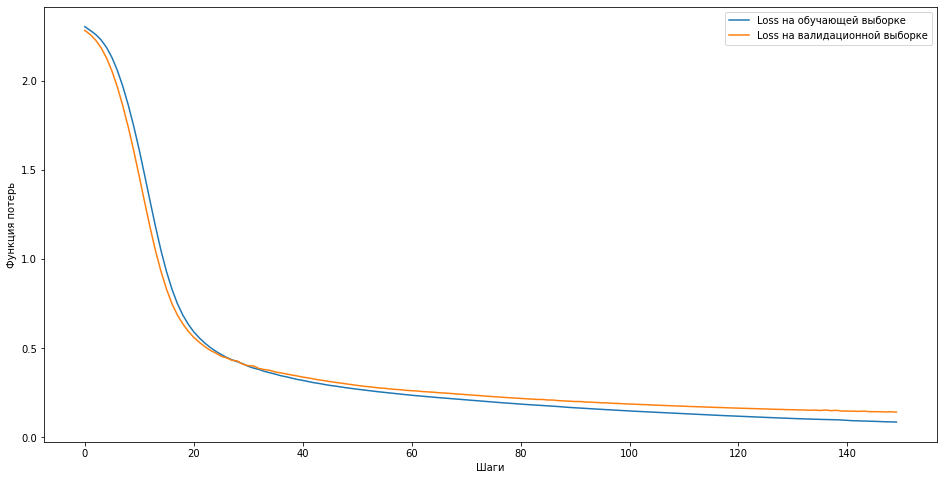

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(train_loss_history, label='Loss на обучающей выборке')
plt.plot(valid_loss_history, label='Loss на валидационной выборке')
plt.xlabel('Шаги')
plt.ylabel('Функция потерь')
plt.legend()
plt.yticks()
plt.show()

Пропустим выходы через сигмоиду и посчитаем метрику качества на валидационной выборке:

In [ ]:
# посчитаем логиты
logits = model(X_valid_tensor.to(torch.float32)).detach()
# подадим логиты сигмоидной функции и посчитаем вероятности каждого класса
proba = torch.sigmoid(logits).numpy()
# найдем классы: для каждого изображения (состоит из строки с 10 элементами) найдем индекс, который соответствует цифре, с наибольшим значением
prediction = np.argmax(proba, axis=1)
# посчитаем метрику F1
print(f'F1-score: {f1_score(valid_y, prediction, average="macro")}')
print(f'Accuracy: {accuracy_score(valid_y, prediction)}')

F1-score: 0.9571054035593569
Accuracy: 0.9572619047619048


## Готовим submission для Kaggle

In [ ]:
train = pd.read_csv('/content/drive/Datasets/MNIST/train.csv')
test = pd.read_csv('/content/drive/Datasets/MNIST/test.csv')

Сохраним признаки в переменных `train_X` `test_X`, а метку -  в `train_y`. Признаки нормализуем, поделив каждое значение на 255:

In [ ]:
train_X = train.drop(columns='label').values / 255
train_y = train['label'].values

In [ ]:
test_X = test.values / 255

Размеры выборок:

In [ ]:
print(train_X.shape, train_y.shape, test_X.shape)

(42000, 784) (42000,) (28000, 784)


Конвертируем выборки в тензоры:

In [ ]:
X_tensor = torch.tensor(train_X)
y_tensor = torch.tensor(train_y)
test_tensor = torch.tensor(test_X)

Инициализируем модель:

In [ ]:
model = MySecondNN()

Инициализируем оптимизатор:

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

Запускаем цикл обучения:

In [ ]:
epochs = 200

train_loss_history = []

for i in tqdm(range(epochs)):
    # считаем произведение матрицы признаков на матрицу весов
    prediction = model(X_tensor.to(torch.float32))
    # вычисляем функцию потерь, функция активации уже включена
    loss = torch.nn.functional.cross_entropy(prediction, y_tensor) 
    # вычисляем градиент
    loss.backward()
    # делаем шаг градиентного спуска: обновляем веса
    optimizer.step()
    # логируем значение функции потерь
    train_loss_history.append(loss.item())
    # обнуляем градиенты для следующего шага
    optimizer.zero_grad()

100%|██████████| 200/200 [05:22<00:00,  1.61s/it]


Визуализируем значения функции потерь при обучении:

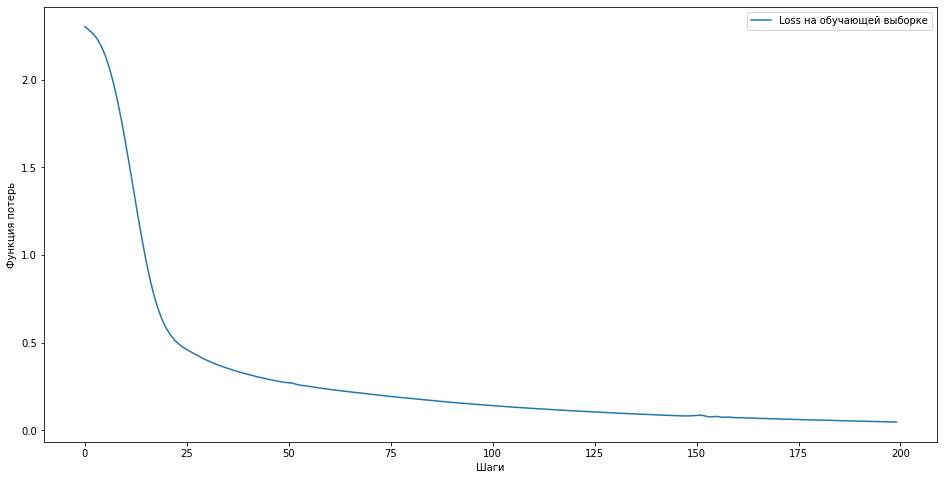

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(train_loss_history, label='Loss на обучающей выборке')
plt.xlabel('Шаги')
plt.ylabel('Функция потерь')
plt.legend()
plt.yticks()
plt.show()

Пропустим выходы через сигмоиду и предскажем классы для тестовой выборки:

In [ ]:
# посчитаем логиты
logits = model(test_tensor.to(torch.float32)).detach()
# подадим логиты сигмоидной функции и посчитаем вероятности каждого класса
proba = torch.sigmoid(logits).numpy()
# найдем классы: для каждого изображения (состоит из строки с 10 элементами) найдем индекс, который соответствует цифре, с наибольшим значением
prediction = np.argmax(proba, axis=1)

Загружаем файл `sample_submission.csv` и сохраняем его в переменной `submission`:

In [ ]:
submission = pd.read_csv('/content/drive/Datasets/MNIST/sample_submission.csv')
submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


Сохранаяем в столбце `Label` результаты предсказания нейросети:

In [ ]:
submission['Label'] = prediction

In [ ]:
submission.to_csv('nn_submission.csv', index=False)

Метрика `Accuracy` на тестовой выборке на платформе `Kaggle`:  **0.96375**.